In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import hvplot.pandas as hvplot
plt.style.use('seaborn')
!pip install ta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
import ta as ta
# Initial imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from pathlib import Path
import pandas as pd

In [15]:
def download(ticker):
# Note: We could have period < 60d and an intraday return
# Just change period to < 60 days and add interval = 1h
    df = yf.download(ticker, 
                period = '2y', # A period of 2 years from today
                prepost = False, # Pre and Post markets included
                threads = True, # Multi-thread processing for faster output.
                interval = '1d')
    return df
df = download("TSLA")
df = df[['Close','Open','High','Low','Volume']]
#data cleaning
print(df.describe())
print(df.isna().sum())

[*********************100%***********************]  1 of 1 completed
            Close        Open        High         Low        Volume
count  504.000000  504.000000  504.000000  504.000000  5.040000e+02
mean   273.493214  273.283774  280.033853  265.689744  5.946617e+07
std    255.728810  255.706394  261.291574  248.758647  3.634726e+07
min     35.793999   36.220001   37.335999   35.397999  1.232800e+07
25%     52.304001   52.112499   53.037000   51.545999  3.339970e+07
50%    156.192001  157.700996  161.004997  152.548004  4.897380e+07
75%    426.692513  430.902496  438.092506  420.602501  7.799000e+07
max    883.090027  891.380005  900.400024  871.599976  3.046940e+08
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64


In [4]:
close_price_change = df.pct_change()

In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 30

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0 # Close
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [7]:
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
scaler = scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
model = Sequential()
number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [12]:
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 20)            1760      
_________________________________________________________________
dropout (Dropout)            (None, 30, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 20)            3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [14]:
model.fit(X_train, y_train, epochs=2, shuffle=False, batch_size=1, verbose=1)

Epoch 1/2
1224/1224 [==============================] - 36s 26ms/step - loss: 0.0624 - mse: 0.0624
Epoch 2/2
1224/1224 [==============================] - 35s 29ms/step - loss: 0.0215 - mse: 0.0215


In [16]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 2s 17ms/step - loss: 0.0152 - mse: 0.0152


[0.015195879153907299, 0.015195879153907299]

In [17]:
predicted = model.predict(X_test)

In [18]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [19]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])

stocks.tail()

,Real,Predicted
Date,,
2021-04-14,716.859985,675.725525
2021-04-15,721.210022,675.726440
2021-04-16,720.407104,675.746521
2021-04-19,720.599976,675.782654
2021-04-20,718.989990,675.828186


<AxesSubplot:title={'center':"Aint worth shit. But damn. Ain't it pretty"}, xlabel='Date'>

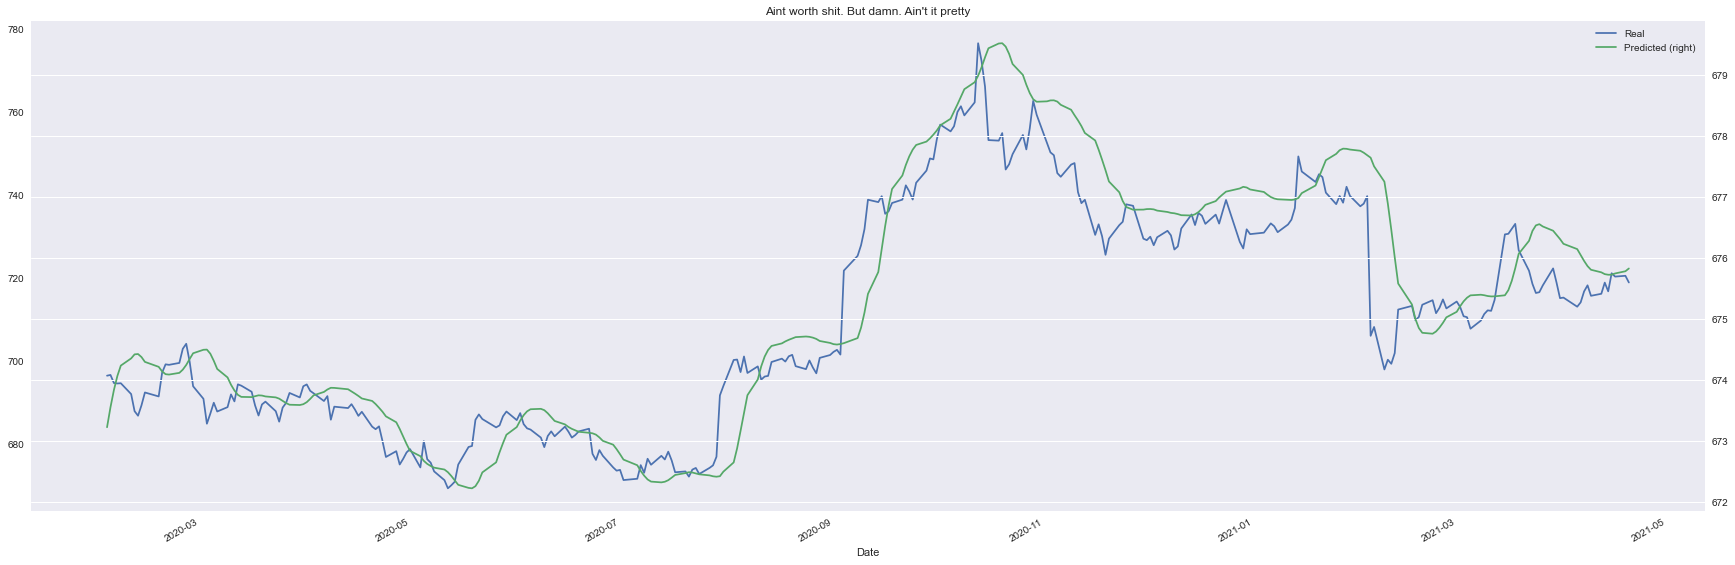

In [20]:
stocks.plot(title = "Aint worth shit. But damn. Ain't it pretty", figsize = (30, 10), secondary_y = 'Predicted')

In [21]:
df.reset_index(inplace = True)

In [26]:
df = df[['Date','Close']]
df.columns = ['Date','Close']
df.tail()

,Date,Close
499,2021-04-14,732.229980
500,2021-04-15,738.849976
501,2021-04-16,739.780029
502,2021-04-19,714.630005
503,2021-04-20,718.989990


In [37]:
close_data = df.Close.values.reshape((-1))
look_back = 30
def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
       
        out = model.predict(x)
        output=scaler.inverse_transform(out)
        prediction_list = np.append(prediction_list, output)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 1
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)   


In [38]:
prediction = pd.DataFrame({"Prediction":forecast, "Date":forecast_dates})
prediction

,Prediction,Date
0,718.989990,2021-04-20
1,711.786194,2021-04-21


In [ ]:
prediction.set_index('Date', inplace = True)

In [ ]:
df.set_index('Date', inplace = True)